In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
import pickle
%pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
bd = pd.read_csv('orders.csv', sep=',')

In [ ]:
# add columns to dataset
def stat_features(bd):
  fast_ma=7
  slow_ma=14
  bd['sred_za_7d']=bd['kol-vo-z'].rolling(window=fast_ma).mean()          #mean orders count by 7 hours
  bd['sred_za_14d']=bd['kol-vo-z'].rolling(window=slow_ma).mean()         #mean orders count by 14 hours
  bd['50%_sz7d+50%_sz14d'] = bd['sred_za_7d'] /2 + bd['sred_za_14d']/2    #sum of 50% mean by 7 hours and 15 hours 
  bd=bd[14:]                                                              #remove NaN
  return bd

## Holiday

In [ ]:
def is_holiday(data):
  holid = [pd.to_datetime('2021-05-01 00:00:00'),
          pd.to_datetime('2021-05-09 00:00:00'),
          pd.to_datetime('2021-06-12 00:00:00'),pd.to_datetime('2021-11-04 00:00:00')]
          
  data['holiday'] = 0
  data['holiday'][(data['date'] == holid[0])] = 1
  data['holiday'][(data['date'] == holid[1])] = 1
  data['holiday'][(data['date'] == holid[2])] = 1
  data['holiday'][(data['date'] == holid[3])] = 1
  return data

## Days until holiday

In [ ]:
def days_until_holiday(data):
  holid = [pd.to_datetime('2021-05-01 00:00:00'),
          pd.to_datetime('2021-05-09 00:00:00'),
          pd.to_datetime('2021-06-12 00:00:00'),pd.to_datetime('2021-11-04 00:00:00')]
  data['days_until_holiday'] = 0
  days_left = {}
  start_date = pd.to_datetime('2021-04-01')
  date = [start_date +pd.DateOffset(days=i)for i in range(244)]
  k = 0
  for i,j in enumerate(date):
    if j < holid[k]:
      days_left[j] = (holid[k] - j).days
    else:
      days_left[j] = 0
      k += 1
    if k > 3:
      break
  for k in range(i + 1, len(date)):
    days_left[date[k]] = -1
  data['days_until_holiday'] = data['date'].map(days_left)
  return data

## Mean by region

In [ ]:
def mean_by_region(data):
  areas_list = [data[data['delivery_area_id']==i]for i in range(len(data['delivery_area_id'].unique()))]
  mean_by_area = [areas_list[i]['kol-vo-z'].mean()for i in range(len(areas_list))]

  data['mean_by_area'] = 0
  old = 0
  new = 0

  for i, j in enumerate(areas_list):
    new += len(j)
    data['mean_by_area'][old:new] = mean_by_area[i]
    old = new
  return data

## Median by region


In [ ]:
def median_by_region(data):
  areas_list = [data[data['delivery_area_id']==i]for i in range(len(data['delivery_area_id'].unique()))]
  median_by_area = [areas_list[i]['kol-vo-z'].median()for i in range(len(areas_list))]
  data['median_by_area'] = 0
  old = 0
  new = 0

  for i, j in enumerate(areas_list):
    new += len(j)
    data['median_by_area'][old:new] = median_by_area[i]
    old = new
  return data



## Mean by week

In [ ]:
def mean_by_week(data):
  data['mean_by_week'] = 0
  mean_by_week_area = []
  global_index = 0
  old = 0
  last_index = 0
  areas_list = [data[data['delivery_area_id']==i]for i in range(len(data['delivery_area_id'].unique()))]

  for i,j in enumerate(areas_list):
    sum_of_orders = 0
    order_count = 0
    days = len(j['date'].value_counts())
    start_date = (j['date'].reset_index(drop=True))[0]
    last_index = j[-1:].index
    if days % 7 != 0:
      part = days % 7
    
    for day, order in zip(j['date'], j['kol-vo-z']):
      if (days >= 7 and day >= start_date + pd.DateOffset(days=7)) or ((days < 7) and (day >= pd.to_datetime((j['date'][-1:].values)[0]) and (last_index == global_index))):
        
        days -= 7
        start_date += pd.DateOffset(days=7)
        if order_count == 0:

          data['mean_by_week'][old:global_index + 1] = 0
        else:
          data['mean_by_week'][old:global_index + 1] = sum_of_orders/order_count
        old = global_index
        sum_of_orders = 0
        order_count = 0

          
      sum_of_orders += order
      order_count += 1
      global_index += 1
  return data

# Median by week

In [ ]:
def median_by_week(data):
  data['median_by_week'] = 0
  median_by_week_area = 0
  global_index = 0
  old = 0
  last_index = 0
  areas_list = [data[data['delivery_area_id']==i]for i in range(len(data['delivery_area_id'].unique()))]

  for i,j in enumerate(areas_list):
    list_of_orders = []
    days = len(j['date'].value_counts())
    start_date = (j['date'].reset_index(drop=True))[0]
    last_index = j[-1:].index
    if days % 7 != 0:
      part = days % 7
    
    for day, order in zip(j['date'], j['kol-vo-z']):
      if (days >= 7 and day >= start_date + pd.DateOffset(days=7)) or ((days < 7) and (day >= pd.to_datetime((j['date'][-1:].values)[0]) and (last_index == global_index))):
        list_of_orders.sort()
        if len(list_of_orders) % 2 == 0:
          median_by_week_area = (list_of_orders[int(len(list_of_orders)/2)] + list_of_orders[int((len(list_of_orders)/2)) -1]) / 2
        else:
          median_by_week_area = list_of_orders[int(len(list_of_orders)/2)]
        days -= 7
        start_date += pd.DateOffset(days=7)
        data['median_by_week'][old:global_index + 1] = median_by_week_area
        old = global_index
        list_of_orders = []

          
      list_of_orders.append(order)
      global_index += 1
  return data

## Standard deviation by week

In [ ]:
def std_by_week(data):
  data['std_by_week'] = 0
  median_by_week_area = 0
  global_index = 0
  old = 0
  last_index = 0
  areas_list = [data[data['delivery_area_id']==i]for i in range(len(data['delivery_area_id'].unique()))]

  for i,j in enumerate(areas_list):
    list_of_orders = []
    days = len(j['date'].value_counts())
    start_date = (j['date'].reset_index(drop=True))[0]
    last_index = j[-1:].index
    if days % 7 != 0:
      part = days % 7
    
    for day, order in zip(j['date'], j['kol-vo-z']):
      if (days >= 7 and day >= start_date + pd.DateOffset(days=7)) or ((days < 7) and (day >= pd.to_datetime((j['date'][-1:].values)[0]) and (last_index == global_index))):
        sttd = np.std(np.array(list_of_orders))
        start_date += pd.DateOffset(days=7)
        data['std_by_week'][old:global_index + 1] = sttd
        old = global_index
        list_of_orders = []
        order_count = 0

          
      list_of_orders.append(order)
      global_index += 1
  return data

## sqrt, log, sqr

In [ ]:
def math_transforms(data):
  data['target_sqrt'] = 0
  data['target_sqrt'][1:]=np.sqrt(data['kol-vo-z'][:-1])
  data['target_log'] = 0
  data['target_log'][1:] = np.log(data['kol-vo-z'][:-1])
  data['target_sqr'] = 0
  data['target_sqr'][1:] = data['kol-vo-z'][:-1]**2
  return data

## Day of week.Is day a weekend

In [ ]:
def day_of_week_and_is_day_weeked(data):
  wod = {}
  weekend = {}
  for i in data['date'].unique():
    wod[pd.to_datetime(i)] = pd.to_datetime(i).weekday()
    weekend[pd.to_datetime(i)] = (pd.to_datetime(i).weekday()) >= 5
  data['weekend'] = data['date'].map(weekend)
  data['day_of_week'] = data['date'].map(wod)
  data['weekend'] = data['weekend'].map({True:1, False:0})
  return data


### Next cells dont need to be run, they are need only to show how we fitted our model

In [ ]:
y = bd[['kol-vo-z']]
X = bd.drop(['kol-vo-z'], axis=1)

LightGBM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [ ]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X_train['date'] = lbl.fit_transform(X_train['date'].astype(str))
X_test['date'] = lbl.fit_transform(X_test['date'].astype(str))

In [ ]:
import lightgbm as lgb

# initialzing the model
model = lgb.LGBMRegressor()

# train the model
model.fit(X_train,y_train)

LGBMRegressor()

In [ ]:
lightR_predict = model.predict(X_test)

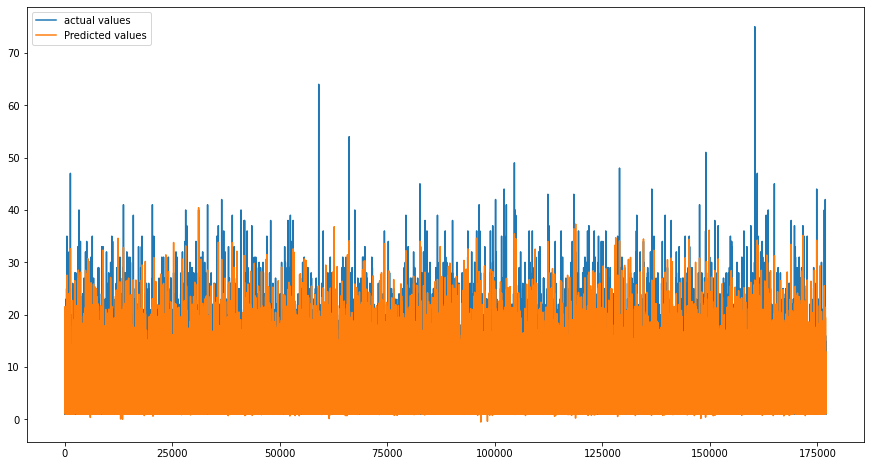

In [ ]:
import matplotlib.pyplot as plt

# fitting the size of the plot
plt.figure(figsize=(15, 8))

# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],lightR_predict, label="Predicted values")

# showing the plotting
plt.legend()
plt.show()

In [ ]:
print('R2:', np.round(metrics.r2_score(y_test, lightR_predict), 2))
print('MAE:',metrics.mean_absolute_error(y_test, lightR_predict))

R2: 0.7
MAE: 1.3855744569642972


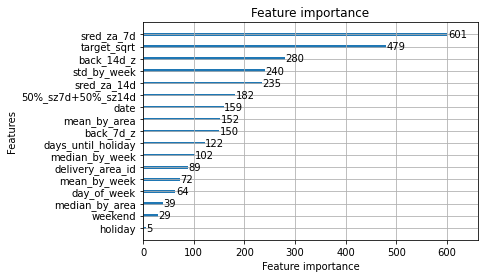

In [ ]:
lgb.plot_importance(model)

In [ ]:
#model.booster_.save_model('mode.txt')

### The function takes as input dataset with target to calculate the features and various statistics. But there is a problem, we want our orders_count prediction model to predict the target which is used to calculate the features - it's a vicious circle. We cant predict target without features which is calculated on target.We noticed it too late and didn't have time to do anything about it.

In [ ]:
def transforms_and_predictions(bd):
  # указываем кол-во заказов  7 и 14 дней назад
  bd = pd.concat([bd, bd['orders_cnt'].shift(7), bd['orders_cnt'].shift(14)], axis=1)
  bd.columns= ['delivery_area_id', 'date','kol-vo-z', 'back_7d_z', 'back_14d_z'] # переименовываю столбцы
  bd = stat_features(bd)
  bd['date'] = pd.to_datetime(bd['date'],errors='coerce') #  столбец date  преобразуем в дату 
  bd_date = bd 

  data = bd
  # Применяем кучу преобразований
  data.date = data.date.astype('str') 
  data.date = data.date.str.slice(start=0, stop=10)
  data['date'] = pd.to_datetime(data['date'])
  data = is_holiday(data)
  data = days_until_holiday(data)
  data = mean_by_region(data)
  data = median_by_region(data)
  data = mean_by_week(data)
  data = std_by_week(data)
  data = median_by_week(data)
  data = math_transforms(data)
  data = day_of_week_and_is_day_weeked(data)

  # Возвращаем время
  bd = data
  bd['date'] = bd_date['date']
  bd['date'] = bd['date'].dt.strftime("%d%m%Y%H%M%S")

  lbl = preprocessing.LabelEncoder()
  bd['date'] = lbl.fit_transform(bd['date'].astype(str))

  bst = lgb.Booster(model_file='mode.txt') # Загружаем веса

  y_pred = bst.predict(bd)

  y_predf = pd.DataFrame(y_pred, columns = ['y_pred'])
  return y_predf